# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator 
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f'There are {azdias.shape[0]} rows in this data set.')
print(f'There are {azdias.shape[1]} columns in this data set.')




There are 891221 rows in this data set.
There are 85 columns in this data set.


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.

def stings_to_list(x):
    new_list=[]
    
    x = x[1:-1].split(',')
   
    for i in x:
        try:
            new_list.append(int(i))
        except:
            new_list.append(i)
    return new_list



In [6]:
#adds a Na_tags column that is the stings from Missing_or_unknow and is now list. 
feat_info['NA_tags'] = feat_info['missing_or_unknown'].apply(stings_to_list)

In [7]:
#checking to make sure the above worked. 
feat_info.head()

,attribute,information_level,type,missing_or_unknown,NA_tags
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [8]:
#setting up an index called att_index 
att_index  = feat_info.set_index('attribute')
#Checking to make sure the att index looks as I would expect it too
att_index.head()

,information_level,type,missing_or_unknown,NA_tags
attribute,,,,
AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
CJT_GESAMTTYP,person,categorical,[0],[0]
FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [9]:
#making a clone of the azdias data to be able to remove set all na. 
na_azdias = azdias[:]

In [10]:
#This is go through all the columns in the data set and turn them into na values 
for column in na_azdias.columns:
    na_azdias[column].replace(att_index.loc[column].loc['NA_tags'],np.NaN,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [11]:
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [12]:
#check to see how many values are null. 
na_azdias.isnull().sum().sum() 

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data = na_azdias.isnull().sum()
print(missing_data)


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [14]:
#turn missing data into precentages
missing_data = missing_data[missing_data > 0]/(na_azdias.shape[0]) * 100
missing_data.sort_values(inplace=True)


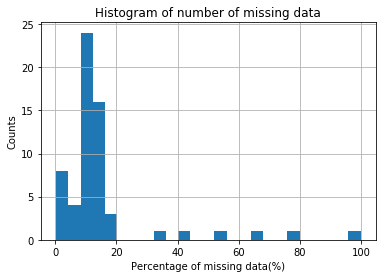

In [15]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_data, bins = 25)

plt.xlabel('Percentage of missing data(%)')
plt.ylabel('Counts')
plt.title('Histogram of number of missing data')
plt.grid(True)
plt.show()




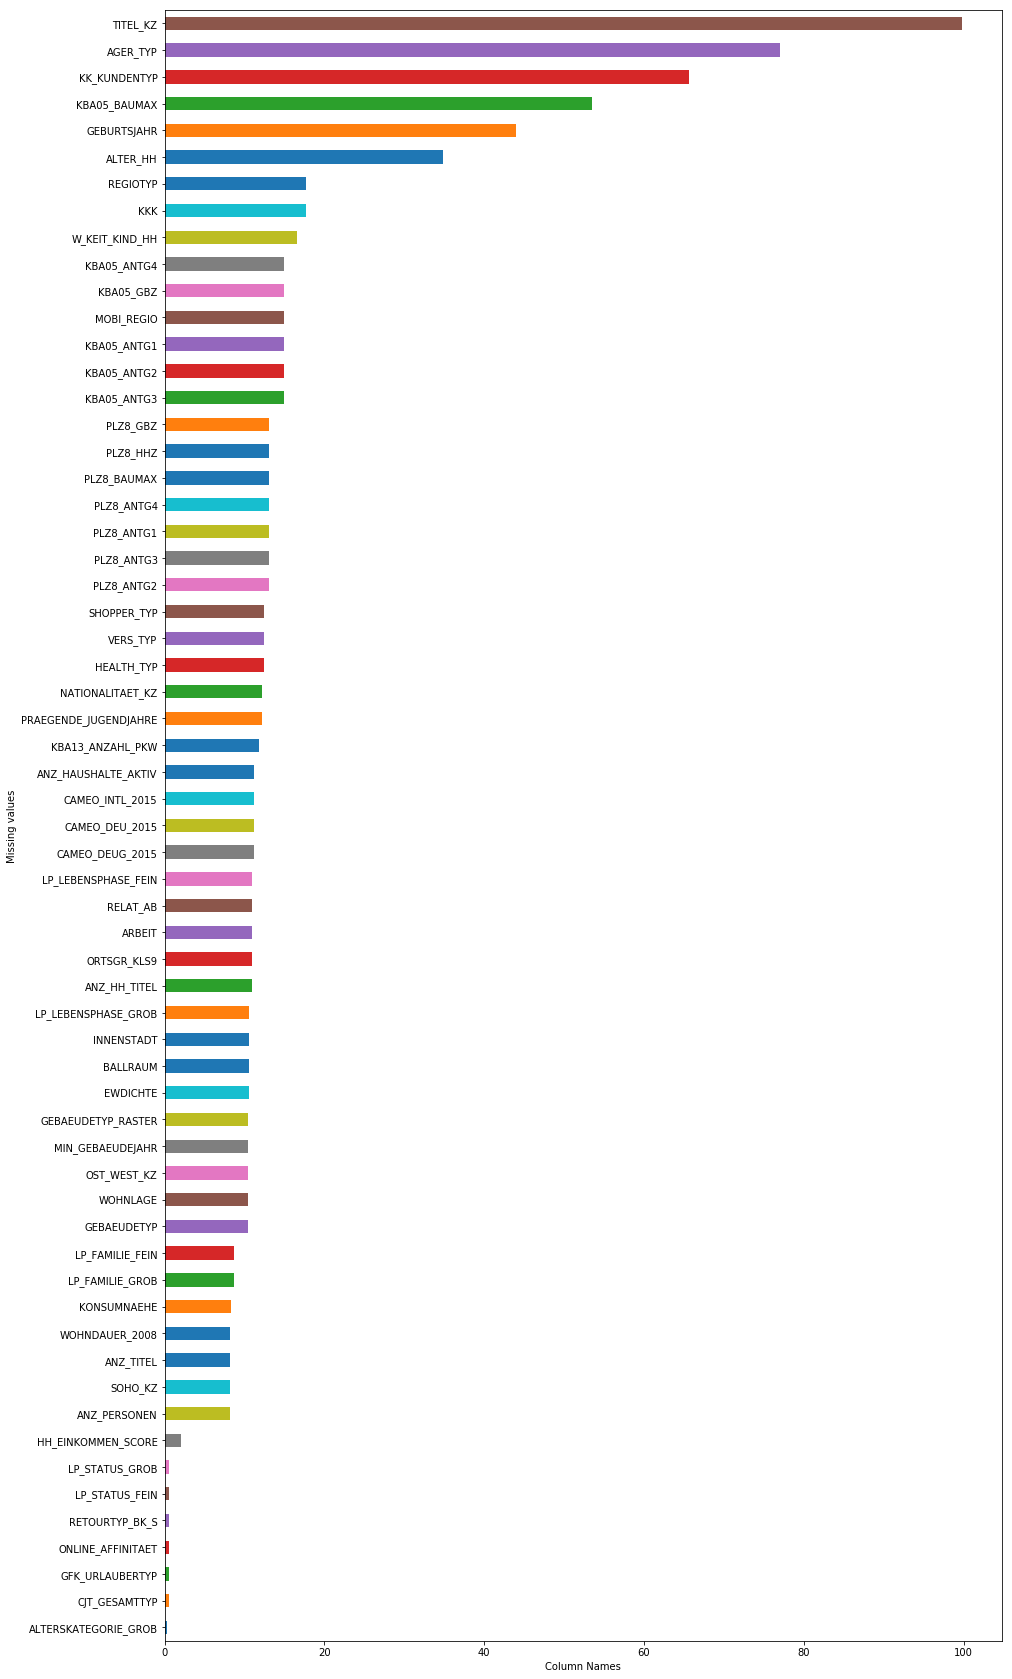

In [16]:
missing_data.plot.barh(figsize=(15,30))
plt.xlabel('Column Names')
plt.ylabel('Missing values')

plt.show()


In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#finding the values to remove:
col_with_the_most_missing_points= [col for col in na_azdias.columns 
               if (na_azdias[col].isnull().sum()/na_azdias.shape[0])
               * 100 > 20]

print(col_with_the_most_missing_points)


['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [18]:
#lets remove the col. found above
for item in col_with_the_most_missing_points:
    na_azdias.drop(item, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [19]:
col_with_the_most_missing_points= [col for col in na_azdias.columns 
               if (na_azdias[col].isnull().sum()/na_azdias.shape[0])
               * 100 > 20]
print(col_with_the_most_missing_points)

[]


#### Discussion 1.1.2: Assess Missing Data in Each Column

Looking at the data, you can see that about 20% of the data has most of the nulls. 
You can even break it down to these 5 columns: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'
As most of the null data is in such a small amount of columns, it seems best to make sure these columns don't through off our models. Thus, we removed them. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
print(f'There are {na_azdias.shape[0]} rows in this data set.')

There are 891221 rows in this data set.


In [21]:
# How much data is missing in each row of the dataset?
missing_rows = na_azdias.isnull().sum(axis=1)

missing_rows.sort_values(ascending=False)



643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
few_of_missing_values = na_azdias[na_azdias.isnull().sum(axis=1) < 15].reset_index(drop=True)
lots_of_missing_values = na_azdias[na_azdias.isnull().sum(axis=1) >= 15].reset_index(drop=True)





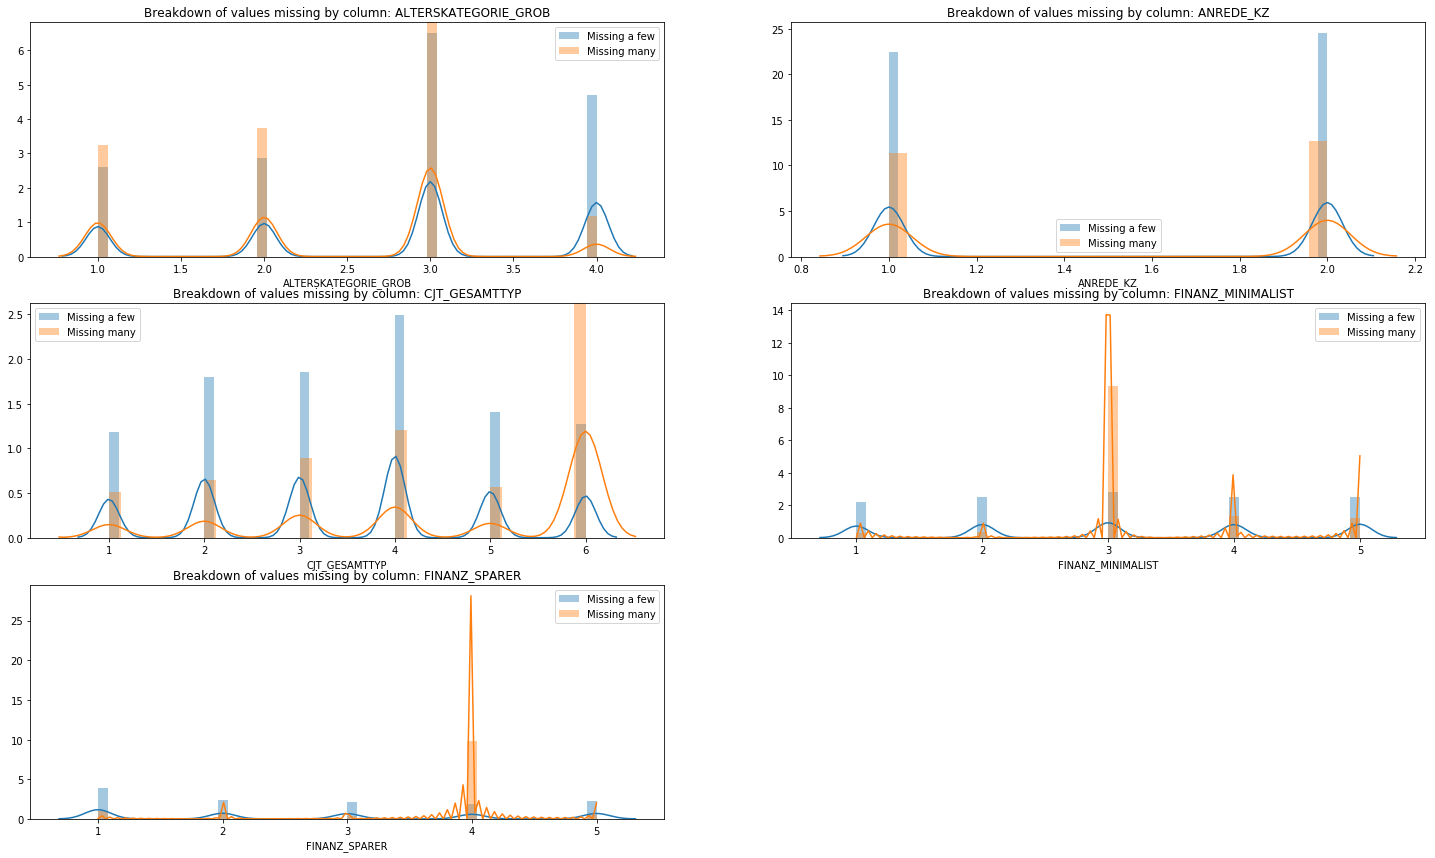

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

plt.figure(figsize=(25,25))
for i, column in enumerate(na_azdias.columns[:5]):
    plt.subplot(5, 2, i+1)
    sns.distplot(few_of_missing_values[column][few_of_missing_values[column].notnull()], label='Missing a few')
    sns.distplot(lots_of_missing_values[column][lots_of_missing_values[column].notnull()], label='Missing many')
    plt.title(f'Breakdown of values missing by column: {column}')
    plt.legend();


#### Discussion 1.1.3: Assess Missing Data in Each Row

From the above graphs you can see that for the most point rows missing the few data points are grouped togehter, where missing many is spread out. I find that Andre_KZ has two distinct bell curves to be very intersting and would love to delve depper into that. I worry that if I drop all the rows with missing data I will effect the over all model, but I belive I can drop the rows with many misisng values and just fill in the ones with a few. 

In [24]:
na_azdias_lots_missing = na_azdias.iloc[lots_of_missing_values.index]

In [25]:
na_azdias_lots_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [26]:
#filling missing values in the few missing with the mean of the value, before and after
for col in few_of_missing_values.columns:
    few_of_missing_values[col] = few_of_missing_values[col].interpolate(limit_direction='both')

In [27]:
few_of_missing_values.isnull().sum()

ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
CJT_GESAMTTYP               0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
FINANZTYP                   0
GFK_URLAUBERTYP             0
GREEN_AVANTGARDE            0
HEALTH_TYP                  0
LP_LEBENSPHASE_FEIN         0
LP_LEBENSPHASE_GROB         0
LP_FAMILIE_FEIN             0
LP_FAMILIE_GROB             0
LP_STATUS_FEIN              0
LP_STATUS_GROB              0
NATIONALITAET_KZ            0
PRAEGENDE_JUGENDJAHRE       0
RETOURTYP_BK_S              0
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
                         ... 
MIN_GEBAEUDEJAHR            0
OST_WEST_KZ                 0
WOHNLAGE  

Looks like we missed some of the many missing values. Let's get a better vew. 

In [28]:
few_of_missing_values.drop(['CAMEO_DEUG_2015'], axis=1, inplace=True)
few_of_missing_values.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)
#CAMEO_INTL
#few_of_missing_values.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)

In [29]:
few_of_missing_values.isnull().sum().sum()

4308

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?
#First lets recall the names for the feat_info columns:
feat_info.set_index('attribute', inplace=True)


In [31]:
feat_info.head()

,information_level,type,missing_or_unknown,NA_tags
attribute,,,,
AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
CJT_GESAMTTYP,person,categorical,[0],[0]
FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [32]:
#Okay, now lets figure out how many data types there  are in the type column. 
feat_info['type'].value_counts() 

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
few_of_missing_values.dtypes

ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ         float64
PRAEGENDE_JUGENDJAHRE    float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
          

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
#which are none binary - As we can keep the binary values, this will be the list that we need to encode
none_binary = []

for col in few_of_missing_values.columns:
    if feat_info.loc[col].type == 'categorical'and len(few_of_missing_values[col].unique()) > 2:
        none_binary.append(col)

print(none_binary) 



['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP']


In [35]:
binary = []
for col in few_of_missing_values.columns:
    if feat_info.loc[col].type == 'categorical'and len(few_of_missing_values[col].unique()) <= 2:
        binary.append(col)
for item in binary:
    print(few_of_missing_values[item])

0         2
1         2
2         2
3         1
4         2
5         2
6         1
7         1
8         2
9         2
10        1
11        2
12        2
13        2
14        2
15        1
16        2
17        1
18        1
19        1
20        1
21        1
22        1
23        2
24        2
25        1
26        2
27        2
28        2
29        1
         ..
787514    2
787515    2
787516    1
787517    1
787518    2
787519    2
787520    2
787521    1
787522    1
787523    2
787524    1
787525    2
787526    2
787527    1
787528    1
787529    2
787530    2
787531    1
787532    2
787533    1
787534    1
787535    1
787536    2
787537    2
787538    2
787539    2
787540    1
787541    2
787542    1
787543    1
Name: ANREDE_KZ, Length: 787544, dtype: int64
0         0
1         1
2         0
3         0
4         0
5         0
6         0
7         1
8         1
9         0
10        0
11        1
12        0
13        0
14        0
15        1
16        1
17        0
18    

When looking through the values, I found the one type that is not numeric OST_WEST_KZ. 
As the models will not know what to do with W we should encoded it. Looking at the data dictionary you can see that W stands for West and 0 Stands for East. So I don't think it will mater what value is 0 and which one is 1. 

In [36]:
few_of_missing_values.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)

In [37]:
few_of_missing_values['OST_WEST_KZ']

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
787514    0
787515    0
787516    0
787517    0
787518    0
787519    0
787520    0
787521    0
787522    0
787523    0
787524    0
787525    0
787526    0
787527    0
787528    0
787529    0
787530    0
787531    0
787532    0
787533    0
787534    0
787535    0
787536    0
787537    0
787538    0
787539    0
787540    0
787541    0
787542    0
787543    0
Name: OST_WEST_KZ, Length: 787544, dtype: int64

I found the FINANZTYP to be an intersesting catigory. Most descriptive financial type for individual. Let's make sure that it is correctly encoded. 


In [38]:
# Re-encode categorical variable(s) to be kept in the analysis.
few_of_missing_values['FINANZTYP'].value_counts()



6    288034
1    194408
5    105447
2    103343
4     55468
3     40844
Name: FINANZTYP, dtype: int64

Okay, FINANZTYP looks good, but I don't want a bad value to come through and I don't want to check one by one, so lets check them all at once. 

In [39]:
for item in none_binary:
    print(few_of_missing_values[item].value_counts())

4.000000    196143
3.000000    145717
2.000000    140731
5.000000    110489
6.000000    100084
1.000000     92288
3.500000       730
2.500000       536
4.500000       474
1.500000       192
5.500000       128
4.666667         5
3.666667         4
3.333333         3
4.333333         3
5.333333         3
2.666667         3
2.333333         3
2.333333         2
3.333333         2
1.666667         2
4.666667         1
2.666667         1
Name: CJT_GESAMTTYP, dtype: int64
6    288034
1    194408
5    105447
2    103343
4     55468
3     40844
Name: FINANZTYP, dtype: int64
12.000000    127504
10.000000    102201
8.000000      82656
11.000000     74568
5.000000      70368
4.000000      60473
9.000000      56465
3.000000      53138
1.000000      50436
2.000000      41068
7.000000      40701
6.000000      25901
7.500000        326
6.500000        319
8.500000        267
9.500000        216
5.500000        216
10.500000       186
4.500000        170
11.500000       131
3.500000         94
2.50000

Now that we have a list of columns that could use some re-encoding we need to fix this. 

In [40]:
non_binary_needs_to_be_reencoding = ['GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN',
                                    'LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP']

for item in non_binary_needs_to_be_reencoding:
    few_of_missing_values[item] = round(few_of_missing_values[item],0)

In [41]:
#lets make sure that the values have been cleaned up. 
for item in none_binary:
    print(few_of_missing_values[item].value_counts())

4.000000    196143
3.000000    145717
2.000000    140731
5.000000    110489
6.000000    100084
1.000000     92288
3.500000       730
2.500000       536
4.500000       474
1.500000       192
5.500000       128
4.666667         5
3.666667         4
3.333333         3
4.333333         3
5.333333         3
2.666667         3
2.333333         3
2.333333         2
3.333333         2
1.666667         2
4.666667         1
2.666667         1
Name: CJT_GESAMTTYP, dtype: int64
6    288034
1    194408
5    105447
2    103343
4     55468
3     40844
Name: FINANZTYP, dtype: int64
12.0    127636
10.0    102606
8.0      83251
11.0     74576
5.0      70371
4.0      60739
9.0      56473
3.0      53140
1.0      50436
2.0      41172
7.0      40705
6.0      26439
Name: GFK_URLAUBERTYP, dtype: int64
1.0     406905
10.0    129651
2.0     102124
11.0     48550
8.0      22389
7.0      19515
6.0      16663
4.0      14027
5.0      11806
9.0      10758
3.0       5156
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    406

Well this cleaned most of the non_binary values, but lets do a little more cleaning by dropping the ones that idd not round.

In [42]:
need_to_drop  = ['CJT_GESAMTTYP','VERS_TYP']

for item in need_to_drop:
    few_of_missing_values.drop(item, axis=1, inplace=True)

    Now that we have removed some areas with high nulls, lets see how things look now. 

In [43]:
for item in none_binary:
    if item in need_to_drop:
        continue
    else:    
        print(few_of_missing_values[item].value_counts())

6    288034
1    194408
5    105447
2    103343
4     55468
3     40844
Name: FINANZTYP, dtype: int64
12.0    127636
10.0    102606
8.0      83251
11.0     74576
5.0      70371
4.0      60739
9.0      56473
3.0      53140
1.0      50436
2.0      41172
7.0      40705
6.0      26439
Name: GFK_URLAUBERTYP, dtype: int64
1.0     406905
10.0    129651
2.0     102124
11.0     48550
8.0      22389
7.0      19515
6.0      16663
4.0      14027
5.0      11806
9.0      10758
3.0       5156
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    406905
5.0    188482
2.0    105027
4.0     52389
3.0     34741
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206027
9.0     133292
2.0     111434
10.0    110804
4.0      74054
3.0      68869
6.0      29448
5.0      27222
8.0      17104
7.0       9290
Name: LP_STATUS_FEIN, dtype: int64
1.0    316920
2.0    170875
4.0    150861
5.0    110556
3.0     38332
Name: LP_STATUS_GROB, dtype: int64
1.0    684402
2.0     70944
3.0     32198
Name: NATIONALITAET_KZ, dtype: int64
1.0   

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [44]:
#Okay first weneed to lookk at the mixed value
mixed_type = []
for item in few_of_missing_values.columns:
    if feat_info.loc[item].type == 'mixed':
        mixed_type.append(item)
        
mixed_type

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [45]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
few_of_missing_values['PRAEGENDE_JUGENDJAHRE'].value_counts()



14.000000    181813
8.000000     141638
10.000000     86289
5.000000      84680
3.000000      53752
15.000000     41735
11.000000     37502
9.000000      35241
6.000000      26212
12.000000     25969
4.000000      20869
1.000000      20489
2.000000       7572
13.000000      6216
7.000000       4877
9.500000       2122
6.500000       1581
8.500000       1515
7.500000       1229
5.500000       1022
11.500000       982
12.500000       966
14.500000       637
10.500000       598
4.500000        494
3.500000        165
13.500000       104
12.666667        97
8.666667         90
11.333333        82
              ...  
4.250000          2
6.750000          2
10.666667         2
6.250000          2
5.750000          2
10.250000         2
12.750000         2
1.666667          2
9.200000          2
1.666667          1
9.800000          1
8.800000          1
13.750000         1
11.800000         1
9.333333          1
5.200000          1
7.400000          1
9.250000          1
2.750000          1


Looks like we could use some cleaning of the PRAEGENDE_JUGENDJAHRE values. 

In [46]:
few_of_missing_values['PRAEGENDE_JUGENDJAHRE'] = round(few_of_missing_values['PRAEGENDE_JUGENDJAHRE'],0)

In [47]:
few_of_missing_values['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182589
8.0     144474
10.0     89138
5.0      84768
3.0      53775
15.0     41762
11.0     37648
9.0      35425
6.0      28888
12.0     27970
4.0      21591
1.0      20489
2.0       7661
13.0      6363
7.0       5003
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

Looking much better. Now What does the above code mean? Lets Look at the Data Dictionary to figure that out.


-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

So each number comunicates three facts; the decade, if the move was Mainstream or Avantagrde and if the  was E or W. 

We will focuse on two new varibable. 

Dominating movement of person's youth
1.Mainstream
2.Avantagrde

Decade
1: 40s
2: 50s
3: 60s
4: 70s
5: 80s
6: 90s



In [48]:
#We will create the new values by using pandas map function. 
#Frist we will need dictions to use to map the new values. 

dominating_movement_in_youth = {#Mainstream
                                1:1, 3:1, 5:1, 8:1, 10:1, 12:1, 14:1, 
                                #Avantagrde
                                2:2, 4:2,  6:2 ,  7:2 , 9:2, 11:2, 13:2, 15:2
                               }

decade = { #40's 
            1:1, 2:1,
            #50's
            3:2, 4:2, 
            #60's
            5:3, 6:3, 7:3,
            #70's
            8:4, 9:4,
            #80's
            10:5, 11:5, 12:5, 13:5,
            #90's
            14:6, 15:6 
}

In [49]:
# Now adding the new columns to the dataframe 
few_of_missing_values['ENG_DECADE'] = few_of_missing_values['PRAEGENDE_JUGENDJAHRE'].map(decade)
few_of_missing_values['ENG_MOVEMENT'] = few_of_missing_values['PRAEGENDE_JUGENDJAHRE'].map(dominating_movement_in_youth)

In [50]:
#lets make sure it worked 
few_of_missing_values['ENG_DECADE'].value_counts()

6    224351
4    179899
5    161119
3    118659
2     75366
1     28150
Name: ENG_DECADE, dtype: int64

In [51]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
few_of_missing_values["CAMEO_INTL_2015"].value_counts()



51    133335
41     91842
24     90154
14     62141
43     56289
54     45220
25     39197
22     32671
45     25959
13     25957
23     24741
55     23789
52     20479
34     18397
31     18148
15     16857
44     14709
12     13046
35     10288
32     10262
33      9755
Name: CAMEO_INTL_2015, dtype: int64

once again the data dicionay shows us that the codes actaul encode two diffrenct data points

Life Stage 
1. Pre-Family Couples & Singles<br>
2. Young Couples With Children<br>
3. Families With School Age Children<br>
4. Older Families &  Mature Couples<br>
5. Elders In Retirement<br>

Wealth<br>
1. Wealthy Households<br>
2. Prosperous Households<br>
3. Comfortable Households<br>
4. Less Affluent Households<br>
5. Poorer Households<br>

But unlike PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015 has the data encoded by first and second digit. 
So we will just need to seprate the digits to find the right endoding. 

In [52]:
#first we will need a function to seprage wealth values from life stage. 

def wealth_vs_lifestage_encodin(x, value):
     if pd.isnull(x):
            return np.nan
     elif value == 'wealth':
        return int(str(x)[0])
     else:
        return int(str(x)[1])


In [53]:
few_of_missing_values['wealth'] = few_of_missing_values['CAMEO_INTL_2015'].apply(wealth_vs_lifestage_encodin, value='wealth')
few_of_missing_values['lifestage'] = few_of_missing_values['CAMEO_INTL_2015'].apply(wealth_vs_lifestage_encodin, value='lifestage')

In [54]:
few_of_missing_values['wealth'].value_counts()

5.0    222823
4.0    188799
2.0    186763
1.0    118001
3.0     66850
Name: wealth, dtype: int64

In [55]:
few_of_missing_values['lifestage'].value_counts()

1.0    243325
4.0    230621
3.0    116742
5.0    116090
2.0     76458
Name: lifestage, dtype: int64

In [56]:
#let's take a look at what type of encoding are being used for the other values. 
for item in mixed_type:
    print(item)
    print(few_of_missing_values[item].value_counts())

LP_LEBENSPHASE_FEIN
1.00     58760
5.00     53084
6.00     44040
2.00     37350
8.00     29680
7.00     25714
13.00    25468
11.00    25380
29.00    25143
10.00    24368
31.00    22506
12.00    22418
30.00    21293
15.00    19852
3.00     19323
19.00    19089
37.00    17337
4.00     17198
20.00    17169
14.00    16882
32.00    15956
39.00    15148
16.00    14538
40.00    14119
27.00    13402
35.00    13044
38.00    13017
21.00    12835
9.00     12665
34.00    12384
         ...  
36.80        1
13.60        1
4.60         1
12.25        1
27.75        1
28.20        1
28.80        1
33.20        1
19.80        1
31.80        1
28.25        1
8.20         1
8.80         1
13.75        1
16.20        1
15.80        1
28.60        1
15.80        1
2.80         1
15.20        1
11.20        1
28.75        1
5.60         1
6.20         1
7.40         1
6.80         1
21.40        1
10.60        1
22.25        1
28.40        1
Name: LP_LEBENSPHASE_FEIN, Length: 313, dtype: int64
LP_LEBENSPHA

LP_LEBENSPHASE_FEIN has a single encouded meaning ranging from 1-40.
As some of the values have values in the fractional part that don't consided with the Data Dictionary. As these are small in value, often with only 1 in the whole dataset, we will consider these to be enter errors and will round them much like how I handled the data in PRAEGENDE_JUGENDJAHRE

This is also true for LP_LEBENSPHASE_GROB, PLZ8_BAUMAX

In [57]:
few_of_missing_values['LP_LEBENSPHASE_FEIN'] = few_of_missing_values['LP_LEBENSPHASE_FEIN'].round(0)
few_of_missing_values['LP_LEBENSPHASE_GROB'] = few_of_missing_values['LP_LEBENSPHASE_GROB'].round(0)
few_of_missing_values['PLZ8_BAUMAX'] = few_of_missing_values['PLZ8_BAUMAX'].round(0)

#### Discussion 1.2.2: Engineer Mixed-Type Features
The values in PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were a little more complecated and need a more complecated fix. The other 4 vlaues seemed to just have some data entry erros and a low count of erros. Thuse a simple rounding fix worked with out to much risk to the modeles that will be built on this data. 



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [58]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
few_of_missing_values.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)
few_of_missing_values.drop("CAMEO_INTL_2015", axis=1, inplace=True)


In [59]:
few_of_missing_values.isnull().sum()


ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
FINANZTYP                   0
GFK_URLAUBERTYP             0
GREEN_AVANTGARDE            0
HEALTH_TYP                  0
LP_LEBENSPHASE_FEIN         0
LP_LEBENSPHASE_GROB         0
LP_FAMILIE_FEIN             0
LP_FAMILIE_GROB             0
LP_STATUS_FEIN              0
LP_STATUS_GROB              0
NATIONALITAET_KZ            0
RETOURTYP_BK_S              0
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
SEMIO_RAT                   0
SEMIO_KRIT                  0
                         ... 
OST_WEST_KZ                 0
WOHNLAGE                    0
KBA05_ANTG

We can see that there are two values that still have lots of nagative value. Let's quickly check to make sure there is only the two that jump out.  

Okay, now that we have confirmed that it is only two values that we created early lets fix them. 

In [60]:
few_of_missing_values['wealth'] = few_of_missing_values['wealth'].interpolate(limit_direction='both') 
few_of_missing_values['lifestage'] = few_of_missing_values['lifestage'].interpolate(limit_direction='both')



In [61]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
check_for_none = few_of_missing_values.isnull().sum()
for item in check_for_none:
    if item > 0:
        print (item)
    



Now, let's check to make sure this worked as expected

In [62]:
check_for_none = few_of_missing_values.isnull().sum()
counter = 0 
for item in check_for_none:
    if item > 0:
        counter += 1
if counter <= 0:
    print("There are no longer any missing values.")

There are no longer any missing values.


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [63]:
def clean_data(df):

    # convert missing value codes into NaNs
    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    #adds a colm to feat_info called NA_tags that is the cleanded version of the mssing_or unknow_strings
    feat_info['NA_tags'] = feat_info['missing_or_unknown'].apply(stings_to_list)

    
    #setting up an index called att_index 
    att_index  = feat_info.set_index('attribute')
    
    #This is go through all the columns in the data set and turn them into na values 
    
    for column in df.columns:
         df[column].replace(att_index.loc[column].loc['NA_tags'],np.NaN,inplace=True)
    
    
    # remove selected columns 
    columns_to_be_removed = ["AGER_TYP", "GEBURTSJAHR", "TITEL_KZ", "ALTER_HH", "KK_KUNDENTYP", "KBA05_BAUMAX", 
                             "CAMEO_DEUG_2015","CAMEO_DEU_2015"]
    #dop columns
    for item in columns_to_be_removed: 
        df.drop(item, axis=1, inplace=True) 


    #remove selected columns rows
    few_missing = df[df.isnull().sum(axis=1) < 10].reset_index(drop=True)
    #interpolate the few missing values 
    for col in few_missing.columns:
        few_missing[col] = few_missing[col].interpolate(limit_direction='both')
    
    # select, re-encode, and engineer column values.
   
   #none_binary
    non_binary_needs_to_be_reencoding = ['GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN',
                               'LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP']
    for item in non_binary_needs_to_be_reencoding:
           few_missing [item] = round(few_missing[item],0)
   
    need_to_drop  = ['CJT_GESAMTTYP','VERS_TYP']

    for item in need_to_drop:
        few_missing.drop(item, axis=1, inplace=True)

    #reencoding W and O to 1 and 0 
    few_missing.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)

    #rounded to remove any with small amount of errors. 
    non_binary_needs_to_be_reencoding = ['GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN',
                                    'LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP']

    for item in non_binary_needs_to_be_reencoding:
        few_missing[item] = round(few_missing[item],0)

    #mixed values 
    mixed_type = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']

    few_missing['PRAEGENDE_JUGENDJAHRE'] = round(few_missing['PRAEGENDE_JUGENDJAHRE'],0)
    dominating_movement_in_youth = {#Mainstream
                                1:1, 3:1, 5:1, 8:1, 10:1, 12:1, 14:1, 
                                #Avantagrde
                                2:2, 4:2,  6:2 ,  7:2 , 9:2, 11:2, 13:2, 15:2
                               }

    decade = {#40's 
            1:1, 2:1,
            #50's
            3:2, 4:2, 
            #60's
            5:3, 6:3, 7:3,
            #70's
            8:4, 9:4,
            #80's
            10:5, 11:5, 12:5, 13:5,
            #90's
            14:6, 15:6}

    few_missing['ENG_DECADE'] = few_missing['PRAEGENDE_JUGENDJAHRE'].map(decade)
    few_missing['ENG_MOVEMENT'] = few_missing['PRAEGENDE_JUGENDJAHRE'].map(dominating_movement_in_youth)
    

    #Now to clean up CAMEO_INTL_2015
    few_missing['wealth'] = few_missing['CAMEO_INTL_2015'].apply(wealth_vs_lifestage_encodin, value='wealth')
    few_missing['lifestage'] = few_missing['CAMEO_INTL_2015'].apply(wealth_vs_lifestage_encodin, value='lifestage')
    few_missing.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    

    # Now to drop the remaining mixed values
    few_missing['LP_LEBENSPHASE_FEIN'] = few_missing['LP_LEBENSPHASE_FEIN'].round(0)
    few_missing['LP_LEBENSPHASE_GROB'] = few_missing['LP_LEBENSPHASE_GROB'].round(0)
    few_missing['PLZ8_BAUMAX'] = few_missing['PLZ8_BAUMAX'].round(0)
   
    
    #Now a little more cleaning up:
    few_missing['wealth'] = few_missing['wealth'].interpolate(limit_direction='both') 
    few_missing['lifestage'] = few_missing['lifestage'].interpolate(limit_direction='both')
       

    #finaly check to make sure that there are no NaN values
    #TO-DO: change check to reuturn a list of items > 0 or return few_missing	
    return few_missing 
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [64]:
print(pd.__version__)

0.23.3


In [65]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
few_of_missing_values[few_of_missing_values.columns] = scaler.fit_transform(few_of_missing_values[few_of_missing_values.columns].values)
#As we are using pandas version 23, I'm using the values methodid. If you are using pandas > 24 you should change this to to_numpy()
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.values.html

In [66]:
few_of_missing_values.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ENG_DECADE,ENG_MOVEMENT,wealth,lifestage
0,-1.765181,0.958218,-1.490890,1.539288,-1.043949,1.467187,0.972646,1.331434,-1.346084,0.710290,...,-0.649179,1.430595,0.558989,-0.171001,-0.130783,0.680322,1.157603,-0.552814,1.182214,-1.260865
1,0.199589,0.958218,-1.490890,0.866362,-1.770337,-0.569182,0.256102,1.331434,-1.346084,0.710290,...,-0.649179,0.399681,0.558989,-0.171001,-0.130783,-0.792240,1.157603,1.808926,-0.867760,0.759222
2,1.181974,0.958218,0.686283,-0.479491,1.135215,-0.569182,-1.176986,-0.808128,1.048657,-1.816331,...,-0.649179,-0.631233,0.558989,-1.174610,-1.000595,-0.055959,-0.224639,-0.552814,-1.551084,-0.587503
3,0.199589,-1.043604,0.686283,0.193436,0.408827,-1.247971,0.256102,-0.808128,0.569708,-0.693388,...,0.038732,-0.631233,-0.344181,0.832608,0.304123,1.416602,-0.224639,-0.552814,0.498889,0.085860
4,-1.765181,0.958218,-0.039441,-1.152417,1.135215,-0.569182,-0.460442,1.331434,-0.867136,-1.816331,...,-0.649179,1.430595,1.462159,-1.174610,-1.000595,-0.055959,-1.606882,-0.552814,1.182214,0.759222


### Discussion 2.1: Apply Feature Scaling

Standard Scaler will handeld the varring scales for columns by reducing the mean to 0 and the standarded divation to 1. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [67]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca_few_of_missing_values = pca.fit_transform(few_of_missing_values)
#Find the explained variance ratio
pca_exp_var = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(pca_exp_var)





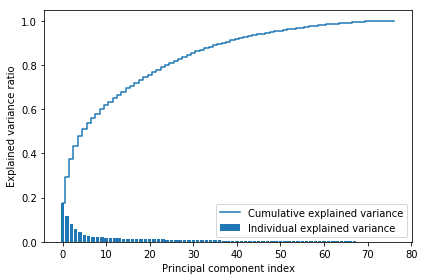

In [68]:
#Now to make the plot
# Create the visualization plot
#
plt.bar(range(0,len(pca_exp_var)), pca_exp_var, alpha=None, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [69]:
# Investigate the variance accounted for by each principal component.
#I wasn't sure the best way to choice the principal componet, I found this artical very helpful https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
#Let's test at 30 features
pca = PCA(n_components = 30)
pca_n_30_few_of_missing_values = pca.fit_transform(few_of_missing_values)
#Find the explained variance ratio
pca_exp_var = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(pca_exp_var)



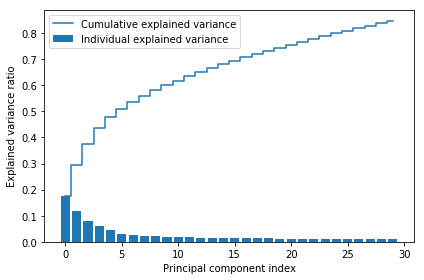

In [70]:
plt.bar(range(0,len(pca_exp_var)), pca_exp_var, alpha=None, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [71]:
# Investigate the variance accounted for by each principal component.
#I wasn't sure the best way to choice the principal componet, I found this artical very helpful https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
#Let's test at 30 features
pca = PCA(n_components = 10)
pca_n_10_few_of_missing_values = pca.fit_transform(few_of_missing_values)
#Find the explained variance ratio
pca_exp_var = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(pca_exp_var)
print(len(pca_exp_var))



10


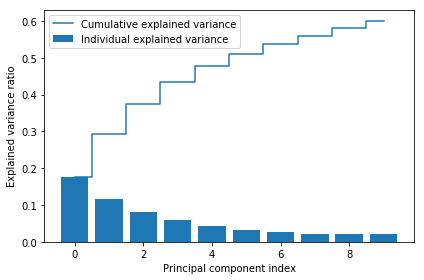

In [72]:
plt.bar(range(0,len(pca_exp_var)), pca_exp_var, alpha=None, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [73]:
pca = PCA(n_components = .85)
pca_n_85_few_of_missing_values = pca.fit_transform(few_of_missing_values)
#Find the explained variance ratio
pca_exp_var = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(pca_exp_var)

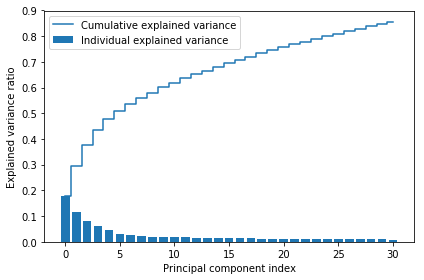

In [74]:
plt.bar(range(0,len(pca_exp_var)), pca_exp_var, alpha=None, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [75]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 10)
pca_final = pca.fit_transform(few_of_missing_values)
pca_exp_var = pca.explained_variance_ratio_
print(len(pca_exp_var))


10


### Discussion 2.2: Perform Dimensionality Reduction

Durning my research, I found that aming for an explained varinance ratio of about 85% is a good goal. 
I was able to use the n_componets precentage option to achive this. I confirmed with the above graphs. This leaves me with 31 componites. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [76]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

import pprint

def pca_weights(pca, i):
    map_weights = {}
    for index, col_name in enumerate(few_of_missing_values.columns):
        map_weights[col_name] = pca.components_[i][index]
    
    sorted_weights = sorted(map_weights.items(), key= operator.itemgetter(1), reverse=True)
    
    return sorted_weights

weights_1 = pca_weights(pca,1)

#print top 5 - bottom five
print('top 5 value')
print(weights_1[0])
print(weights_1[1])
print(weights_1[2])
print(weights_1[3])
print(weights_1[4])
print("\n")
print("bottom five\'lowest on top'")
print(weights_1[-1])
print(weights_1[-2])
print(weights_1[-3])
print(weights_1[-4])
print(weights_1[-5])


top 5 value
('ALTERSKATEGORIE_GROB', 0.2674397047423922)
('FINANZ_VORSORGER', 0.23898787877708022)
('SEMIO_ERL', 0.22791204463503273)
('SEMIO_LUST', 0.18615413420765192)
('RETOURTYP_BK_S', 0.16304909647582003)


bottom five'lowest on top'
('SEMIO_REL', -0.25915212335280935)
('ENG_DECADE', -0.25551172539530465)
('FINANZ_SPARER', -0.24923735985052284)
('SEMIO_PFLICHT', -0.23585329771677685)
('SEMIO_TRADV', -0.2346093330948755)


In [77]:
def print_top_bottom_five(list):
    print('top 5 value')
    print(list[0])
    print(list[1])
    print(list[2])
    print(list[3])
    print(list[4])
    print("\n")
    print("bottom five\'lowest on top'")
    print(list[-1])
    print(list[-2])
    print(list[-3])
    print(list[-4])
    print(list[-5])


The fist componats top values are ALTERSKATEGORIE_GROB = AGE CATEGORY Rough = Estimated age based on given name analysis, FINANZ_VORSORGER =FINANCIAL PROVISION Financial typology, for each dimension: 
SEMIO_ERL Personality typology, for each dimension. This principle componat seems most intrested in the age, how furgaul, or how much they spend, and what is important to them such as family culuter, dreamfull. These 3 dat points to seem to build an interstering vew of the shopwer. 

While on the nagative end this looks at SEMIO_REL, which shares the same encoding as SEMIO_ERL, ENG_DECADE  again looking at age, and FINANZ_SPARER which looks at the shoper type. 

In [78]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_2 = pca_weights(pca,2)
print_top_bottom_five(weights_2)


top 5 value
('SEMIO_VERT', 0.33763881019235359)
('SEMIO_SOZ', 0.26002308113685763)
('SEMIO_FAM', 0.25277877365607448)
('SEMIO_KULT', 0.2393061758868395)
('FINANZ_MINIMALIST', 0.15104649454301572)


bottom five'lowest on top'
('ANREDE_KZ', -0.36301892631832633)
('SEMIO_KAEM', -0.33163868230360599)
('SEMIO_DOM', -0.30635472140748032)
('SEMIO_KRIT', -0.27076851945330244)
('SEMIO_RAT', -0.20216087852209436)


The second componat is focused with how strong or weak a person is in a few basic personlity types for exmaple social, reilgion, dreamer, event-oriented. 

In [79]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_3 = pca_weights(pca,3)
print_top_bottom_five(weights_3)

top 5 value
('LP_FAMILIE_GROB', 0.33992686119178855)
('LP_FAMILIE_FEIN', 0.33756651245884151)
('LP_LEBENSPHASE_GROB', 0.32874553590870015)
('LP_LEBENSPHASE_FEIN', 0.32088149557206619)
('ANZ_PERSONEN', 0.28311071351042988)


bottom five'lowest on top'
('W_KEIT_KIND_HH', -0.21045199750384083)
('INNENSTADT', -0.16741801642713791)
('WOHNLAGE', -0.16121947604049902)
('BALLRAUM', -0.15732984263306343)
('PLZ8_ANTG1', -0.11302421181612303)


I feel that the the third componant is the most intersting. It foucuse on a the household lookking at the statge of life the family is at, age of family members,  age of the head of household. 
While the nagtive values look at distance from urban and city centers, likelhood of children, qulity of the neigborhood.  

### Discussion 2.3: Interpret Principal Components

A detailed break down of each interpret principal componets have been provided above. 
Review 
principal compnets 1 : Age and spending mentality
principal compnets 2: A person's convition towards social philosophy 
principal compnets 3: Ages and sizes of a household and location of the home. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [80]:
# Over a number of different cluster counts...
def cluster(data,num_cluster):
    kmeans =KMeans(n_clusters = num_cluster)
    model = kmeans.fit(data)
    score = np.abs(kmeans.score(data))
    return score 
    

In [81]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = {}
#we will use a range of 2 to 30. As one cluster is redudent and 31 is the maxium features after pca.
#for  k in range(2,25):
 #   scores[k] = cluster(pca_final, k)
  #  print(f'value {k} has been printed')






In [82]:
#fig, ax = plt.subplots(figsize=(16,10))    
#ax = pd.Series(scores).plot(marker='o', color='slategray')
#ax.set_xticks(np.arange(2, 25), minor=False)  
#ax.set_xlabel("Clusters")
#ax.set_ylabel("Distance to the center")

In [83]:
# Re-fit the k-means model with the selected number of clusters and obtain
kmeans = KMeans(n_clusters = 9)
refit_cluster = kmeans.fit(pca_final)



In [84]:
# cluster predictions for the general population demographics data.
predict_genral = refit_cluster.predict(pca_final)


### Discussion 3.1: Apply Clustering to General Population

Looking at the elbow of the above chart 9 clusters looked to be the most fitting point.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [85]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter = ';')

In [86]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)



In [87]:
#Check to make sure all values are null! 
customers_clean.isnull().sum().sum()


0

In [88]:
#Scale the data 
customer_scaler = StandardScaler()
customers_clean[customers_clean.columns] = customer_scaler.fit_transform(customers_clean[customers_clean.columns].values)

In [89]:
#PCA step for the customer data 
pca = PCA(n_components = 10)
pca_customer = pca.fit_transform(customers_clean)
#Find the explained variance ratio
cust_pca_exp_var = pca.explained_variance_ratio_
sum_eigenvalues = np.cumsum(pca_exp_var)

In [90]:
kmeans_2 = KMeans(n_clusters = 9)
customer_cluster = kmeans_2.fit(pca_customer)

In [91]:
predict_customer = customer_cluster.predict(pca_customer)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [92]:
predict_customer

array([5, 7, 6, ..., 1, 8, 6], dtype=int32)

[Text(0.5,0,'cluster'), Text(0.5,1,'Genral populations by Clusters')]

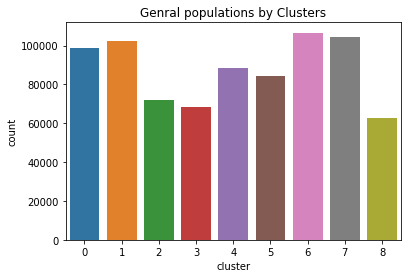

In [93]:
sns.countplot(x = predict_genral).set(title = 'Genral populations by Clusters', xlabel  = 'cluster' )

[Text(0.5,0,'cluster'), Text(0.5,1,'Customer by Clusters')]

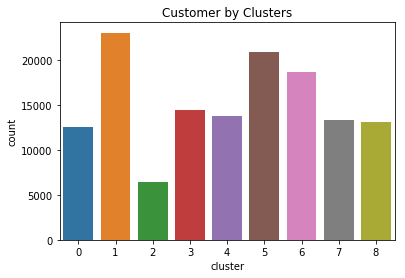

In [94]:
sns.countplot(x = predict_customer).set(title = 'Customer by Clusters', xlabel  = 'cluster' )


In [99]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_centroid_8 = customer_scaler.inverse_transform(pca_customer.inverse_transform(customer_cluster.cluster_centers_[8]))



AttributeError: 'numpy.ndarray' object has no attribute 'inverse_transform'

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.